In [1]:
from __future__ import print_function
import pandas
from pathlib import Path
import time
import numpy 
import matplotlib.pyplot as plt
import time
import pandas
from pathlib import Path
import time
import numpy 
import matplotlib.pyplot as plt
import time
import warnings
import pickle, os, time
import math
from math import ceil
import warnings
import cyipopt
from cyipopt import minimize_ipopt
import random
import os.path
import pickle, os, time
from phe import paillier

In [2]:
# Generating encryption keys
#bit length is 128
public_key, private_key = paillier.generate_paillier_keypair(n_length=128)

start_time_q = time.time()

# Quantization functions
l1 = 28 #l1 - d1 = constant =16; Thus l1 =15+d1
l2 = 36 #l2 > l1
d1= 8
Q_l =-2**(l1-d1-1)
Q_u = 2**(l1-d1-1) - 2**(-d1)

#Defining the lower limit and upper limit of the set Q containing all the quantized parameters, creating it through for loop.
Q_ll = -2**(l1-d1-1);
Q_ul = 2**(l1-d1-1) - 2**(-d1);
res = 2**(-d1)

num_elem = int((Q_ul - Q_ll)/res + 1);
Q = numpy.zeros(num_elem)
Q[0] = Q_ll;
Q[num_elem-1] = Q_ul;

iter_count_q = 0;
iter_count_search = 0;

for i in range(1,num_elem-1):    
    Q[i] = Q[i-1] + res;
    iter_count_q = iter_count_q + 1;
    
end_time_q = time.time();

total_time_q = end_time_q - start_time_q;

print(f"total time to generate the set Q_ld ={total_time_q}, Num of iterations ={iter_count_q}");

total time to generate the set Q_ld =87.86602067947388, Num of iterations =268435454


In [3]:
Model_Results=[]
#List to record the V:
V_record=[]
start_time = time.time();
#steady state values of the original system 
CA_s = 1.9537 #kmol/m3 
T1_s= 401.87 #k 
Q_s=0 #kJ/hr
CAo_S=4 #kmol/m3
To_s=300

#Enter initial values for each state variable: 
CA_i = 1.9537 + 1- CA_s #kmol/m3
T1_i= 401.87 - 10 - T1_s#k  

#################################################################################################
############################## Encryption Parameters & functions ################################
#################################################################################################



#binary search; Begin by finding the midpoint of the array created. 2 Cases- even, odd.
ll = 0;
ul = num_elem - 1;

if((ul - ll)%2 == 0):
    mid_point = int((ul - ll)/2);    
if((ul - ll)%2 != 0):
    mid_point =  int((ul - ll + 1)/2);

it_val = 10;
counter_q = 0;
total_time_search=0;
iter_count_search =0;
single_iter_count_search_record=[]

#Creating a function to output a quantized state  
def quant1(x1,Q,mid_point,ll,ul,it_val,counter_q,iter_count_search):#x to Q
    iter_count_search =0;
    while(it_val>0):
        if((ul - ll) == 1):
            break;
        if(x1 > Q[mid_point]):
            ll = mid_point;    
        if(x1 < Q[mid_point]):
            ul = mid_point;
        #exactly midpoint, success quantized 
        if(x1 == Q[mid_point]):
            x1_q1 = Q[mid_point]
            counter_q = counter_q + 1;
            break;
            #Update mid point for next iter
        if((ul - ll)%2 == 0):
            mid_point = ll + int((ul - ll)/2);
        if((ul - ll)%2 != 0):
            mid_point =  ll + int((ul - ll + 1)/2);    
        iter_count_search = iter_count_search + 1;  
    #if true, no midpoint was equal to x1, no exact match
    if(counter_q == 0):
        if(abs(x1 - Q[ul]) < abs(x1 - Q[ll])):
            x1_q1 = Q[ul];
        if(abs(x1 - Q[ul]) == abs(x1 - Q[ll])):
            if(abs(Q[ul]) < abs(Q[ll])):
                x1_q1 = Q[ul];    
            else:
                x1_q1 = Q[ll];       
        if(abs(x1 - Q[ul]) > abs(x1 - Q[ll])):
            x1_q1 = Q[ll];
    single_iter_count_search_record.append(iter_count_search)
    return x1_q1

def newquant1(val):
    return numpy.fmin(numpy.fmax(numpy.round(val/(2**(-d1)))*(2**(-d1)),Q_l),Q_u)
def quant2(val):
    return int((2**d1)*val%(2**l2))
def quant3(val):
    return numpy.where((val%(2**l2))>=(2**(l2-1)),(val%(2**l2)) - (2**l2),(val%(2**l2)))/(2**d1)
def quantize(val):
    return quant3(private_key.decrypt(public_key.encrypt(int(quant2(quant1(val))))))
def quantize(val):
    return quant3(private_key.decrypt(public_key.encrypt(int(quant2(quant1(val,Q,mid_point,ll,ul,it_val,counter_q,iter_count_search))))))
def newquantize(val):
    return quant3(private_key.decrypt(public_key.encrypt(int(quant2(newquant1(val))))))
realtime_data1=numpy.array([CA_i,T1_i])

###############################################################################################################################

#Creation of lists for recording states at each sampling period.
x1_record=[CA_i] #LISTS
x2_record=[T1_i]

u1_record=[]
u2_record=[]

######### Simulation time #########################
delta= 1e-3 #hr #Sampling 
hc= 1e-4 #hr #Integration Constant
tf = 1 #1hr #Final time

rho= 1000 #kg/m3
Cp=0.231 #kJ/kg k
F= 5 # #m3/hr
V=1 #m3
To=300 #k
CAo=4 #kmol/m3
k0 = 8.46*1e6 # m3/kmol hr
E = 5*1e4 #kJ/kmol
H = -1.15*1e4 #kJ/kmol
R =8.314 #kJ/kmol k

###################################### MPC simulation constants ##############################################
HORIZON=5
NUM_MPC_ITERATION=int(tf/(delta))
NUM_IN_SEQUENCE=int(delta/hc)  ###4*delta 
NUM_OUTPUTS=2 #  x1 x2
NUM_INPUTS=4  # RNN model inputs u1 u2 x1 x2   

NUM_MPC_INPUTS=int((NUM_INPUTS-NUM_OUTPUTS)*HORIZON)  #for FP (we need number of u's, inputs) ##### 4 i.e 2*Horizon 
NUM_MPC_CONSTRAINTS=5   # 0 for no constrains , 1 for Lyaponove constrains

###################### MPC Cost Weight Matrix #####################
#Control Lyapunov Function
P1=1060
P12=22
P2=0.52

def eval_f(x):
    #print("eval_f:",x)
    assert len(x) == int(NUM_MPC_INPUTS)
    offset1=0
    
    x1,x2 =realtime_data1
    
    ### check how to write the inputs 
    for jj in range(HORIZON):

        for jjj in range(NUM_IN_SEQUENCE):
            
            fun_1= (F/V)*(x[2*jj]-x1)-k0*(x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) +k0*(CA_s)*(CA_s)*numpy.exp(-E/(R*(T1_s)))

            fun_2= (F/V)*((To-To_s)-x2)-((H*k0)/(rho*Cp))*((x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) - (CA_s*CA_s)*numpy.exp(-E/(R*(T1_s))))+ (x[2*jj+1])/(rho*Cp*V)
            
            x1= x1 + hc*fun_1 #Eulers explicit method 
            x2= x2 + hc*fun_2

        ## check the equations of the cost 
        offset1 = offset1 -k0*(x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s)))
    return offset1/100


#Computing the gradient of f(x) which represents the cost function and hence its the derivative of the cost function.
def eval_grad_f(x):
    #print("eval_grad_f:",x)
    assert len(x) == int(NUM_MPC_INPUTS)
    step = 1.e-3 # we just have a small step
    objp=objm=0
    grad_f = [0]*NUM_MPC_INPUTS
    xpstep = [0]*NUM_MPC_INPUTS
    xmstep = [0]*NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep=x.copy()
        xmstep=x.copy()
        xpstep[i_mpc_input]  = xpstep[i_mpc_input]+step 
        xmstep[i_mpc_input] = xmstep[i_mpc_input]-step
        objp=eval_f(xpstep) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed +step
        objm=eval_f(xmstep) # This function returns the value of the objective function evaluated with the variable x[i] is perturebed -step
        #print ("obj ", objp, "   objm   ", objm)
        grad_f[i_mpc_input] = (objp - objm) / (2 * step) # This evaluates the gradient of the objetive function with repect to the optimization variable x[i]
    return numpy.array(grad_f)

############### g(x) which is Vdot calculation along with its gradient ####################
def eval_g(x):
    #print("eval_g:",x)
    assert len(x) == int(NUM_MPC_INPUTS)
    g = numpy.array([-1.0]*5)  #why -1
    
    x1,x2 =realtime_data1 

    fun_1= (F/V)*(0-x1)-k0*(x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) +k0*(CA_s)*(CA_s)*numpy.exp(-E/(R*(T1_s)))

    fun_2= (F/V)*((To-To_s)-x2)-((H*k0)/(rho*Cp))*((x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) - (CA_s*CA_s)*numpy.exp(-E/(R*(T1_s))))+ (0)/(rho*Cp*V)       
          
    LfV = (2*P1*x1 +2*P12*x2)*fun_1 + (2*P2*x2 +2*P12*x1)*fun_2 
    
    Lg1V= (2*P1*x1 +2*P12*x2)*(F/V)
    Lg2V= (2*P2*x2 +2*P12*x1)/(rho*Cp*V)
    
    K1s=2
    K2s=12000
    u1_Stab=K1s*(0-x1)
    u2_Stab=K2s*(0-x2)
    
    dV_op2=LfV+Lg1V*x[0]+Lg2V*x[1] 
    dV_Pu2=LfV+Lg1V*u1_Stab+Lg2V*u2_Stab # Under stabilizing control
    V_secure=90
    V_predicted=(P1*x1*x1) + (P2*x2*x2)+ 2*(P12*x1*x2)
    
    if V_predicted<=V_secure:
        
        for j in range(int(HORIZON)):

            for jjj in range(NUM_IN_SEQUENCE):

                fun_1= (F/V)*(x[2*j]-x1)-k0*(x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) +k0*(CA_s)*(CA_s)*numpy.exp(-E/(R*(T1_s)))

                fun_2= (F/V)*((To-To_s)-x2)-((H*k0)/(rho*Cp))*((x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) - (CA_s*CA_s)*numpy.exp(-E/(R*(T1_s))))+ (x[2*j+1])/(rho*Cp*V)

                x1= x1 + hc*fun_1
                x2= x2 + hc*fun_2
            g[j]=(P1*x1*x1) + (P2*x2*x2)+ 2*(P12*x1*x2) - V_secure
    if V_predicted>V_secure:
        g[0]=dV_op2-dV_Pu2-0.000065 #Difference of MPC and P, Vdot 

#      # % Material constraint
#     u1_used = numpy.sum(u1_record[:])
#     if main_iteration <= NUM_MPC_ITERATION - HORIZON - 1:
#         for i in range(HORIZON):
#             u1_used = u1_used + x[i*2]
#     else:
#         for i in range(NUM_MPC_ITERATION - main_iteration):
#             u1_used = u1_used + x[i*2]
#     g[-1] = 0 - u1_used
    
    
    # Material constraint
    material_used = numpy.sum(u1_record[:])
    if main_iteration <= NUM_MPC_ITERATION - HORIZON - 1:
        for controlIteration in range(HORIZON):
            material_used = material_used + x.item(2*controlIteration+0)
    else:
        for controlIteration in range(NUM_MPC_ITERATION - main_iteration):
            material_used = material_used + x.item(2*controlIteration+0)
    g[-1] = 0 - material_used
    #print("-g is ", -g)
    return -g

nnzj = NUM_MPC_CONSTRAINTS*NUM_MPC_INPUTS #Anotehr IPOPT constant 

def eval_jac_g(x):
    #print("eval_jac_g:",x)
    #print ("in eval_jac_g_0")
    # if flag:
    #     list_x = []
    #     list_y=[]
    #     for i in range(int(NUM_MPC_INPUTS / 2)):
    #         list_x = list_x + [i] * NUM_MPC_INPUTS
    #         list_y = list_y +list(range(0, int(NUM_MPC_INPUTS)))
    #     return (numpy.array(list_x),
    #             numpy.array(list_y))
    # else:
    assert len(x) == int(NUM_MPC_INPUTS)
    step = 1e-1 # we just have a small step
    gp=gm=numpy.zeros(NUM_MPC_CONSTRAINTS)
    xpstep=xmstep=numpy.zeros(NUM_MPC_INPUTS)
    jac_g = [[0]*int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep=x.copy()
        xmstep=x.copy()
        xpstep[i_mpc_input] += step 
        xmstep[i_mpc_input] -= step
        gp=eval_g(xpstep)
        gm=eval_g(xmstep)
        for num_constraint in range(NUM_MPC_CONSTRAINTS):
            jac_g[num_constraint][i_mpc_input] = (gp[num_constraint] - gm[num_constraint]) / (2 * step)

    return numpy.array(jac_g)

def apply_new(x):
    return True
def print_variable(variable_name, value):
    for i in range(len(value)):
        print("{} {}".format(variable_name + "["+str(i)+"] =", value[i]))

nnzh = NUM_MPC_INPUTS**2

####################################################################
##### SOLVING THE MPC PROGRAM TO FIND THE OPTIMIZED MPC INPUTS #####
####################################################################
dir_name = os.getcwd()
test = os.listdir(dir_name)

nvar = NUM_MPC_INPUTS
x_lower=[0]* nvar
x_upper=[0]* nvar

ipopt_time_record=[]
Ratio_time_record=[]
calculation_time_record=[]

cons = [
   #{'type': 'eq', 'fun': equalityConstraints, 'jac': equalityConstraints_Jacobian, 'hess': equalityConstraints_Hessian},
   {'type': 'ineq', 'fun': eval_g, 'jac': eval_jac_g}
]
                               

for i in range(HORIZON): 

    x_lower[2*i]= -3.5 #kmol/m3
    x_lower[2*i+1]= -(5*1e5) #kJ/hr


    x_upper[2*i]= 3.5 #kmol/m3
    x_upper[2*i+1]= (5*1e5) #kJ/hr
    
x_L = numpy.array(x_lower)
x_U = numpy.array(x_upper)
bnds = [(x_L[_], x_U[_]) for _ in range(NUM_MPC_INPUTS)]

ncon = NUM_MPC_CONSTRAINTS
g_L = numpy.array([-2e19]*HORIZON)
g_U = numpy.array([0.0]*HORIZON)      #1 is for material constraint       

u1_record=[]
u2_record=[]

real_sensor_measured_values1_q=numpy.zeros(2)

u1_MPC=numpy.zeros(HORIZON)
u2_MPC=numpy.zeros(HORIZON)

print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")
for main_iteration in range(NUM_MPC_ITERATION): #NUM_MPC_ITERATION
    print ("Num Iteration: ", main_iteration+1)
    REAL_SENSOR_VALUES1=realtime_data1
    

    #Transfering the quantized control inputs to the MPC.
    start_time_encryption_tier2=time.time()
    x1,x2=quantize(realtime_data1[0]),quantize(realtime_data1[1])
    print('Difference between MPC and Old x1=',abs(realtime_data1[0]-quantize(realtime_data1[0])) ,' x2=',abs(realtime_data1[1]-quantize(realtime_data1[1])))
    print('Difference between MPC and New x1=',abs(realtime_data1[0]-newquantize(realtime_data1[0])) ,' x2=',abs(realtime_data1[1]-newquantize(realtime_data1[1])))
    end_time_encryption_tier2=time.time()

    print('\n\n\n')
    print("realtime_Real_data: [{}]".format(realtime_data1))
    ###Predicted state values:
    realtime_data1 = x1, x2
    x1,x2 =REAL_SENSOR_VALUES1
    time_1= time.time()
    

    if main_iteration==0:
        x0 = numpy.array([0]*int(NUM_MPC_INPUTS)) #which are u1 and u2
        print("x0 = ", x0);
    else:
        x0=x_MPC

        x0 = numpy.array([0.0]*int(NUM_MPC_INPUTS))

        x0[0:-2] = x_MPC[2:]
        print("x0 is", x0)
    solution = minimize_ipopt(eval_f, jac=eval_grad_f, x0=x0, bounds=bnds,constraints=cons, options={'maxiter':250,'tol': 1e-4})
    print(solution)
    x = solution.x
    time_2=time.time()
    
    x_MPC=x
    print('MPC inputs = ', x)
    for i in range(HORIZON):
        u1_MPC[i]=x[2*i]
        u2_MPC[i]=x[2*i+1]
        
    print("MPC computed control inputs:")
    print("U1, MPC",u1_MPC)
    print("U2, MPC",u2_MPC)
    
    u1=x[0]
    u2=x[1]
    
    #Encryptio-Decryption of all control input computed by the MPC
    print('Difference between MPC and Old u1=',abs(x[0]-quantize(u1)) ,' u2=',abs(x[1]-quantize(u2)))
    print('Difference between MPC and New u1=',abs(x[0]-newquantize(u1)) ,' u2=',abs(x[1]-newquantize(u2)))
    u1 = quantize(u1) 
    u2 = quantize(u2)
    u1_record.append(u1)
    u2_record.append(u2)
    
    
    for jjj in range(NUM_IN_SEQUENCE):
        fun_1= (F/V)*(u1-x1)-k0*(x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) +k0*(CA_s)*(CA_s)*numpy.exp(-E/(R*(T1_s)))

        fun_2= (F/V)*((To-To_s)-x2)-((H*k0)/(rho*Cp))*((x1+CA_s)*(x1+CA_s)*numpy.exp(-E/(R*(x2+T1_s))) - (CA_s*CA_s)*numpy.exp(-E/(R*(T1_s))))+ (u2)/(rho*Cp*V)
            
        x1= x1 + hc*fun_1
        x2= x2 + hc*fun_2

    realtime_data1 =numpy.array([x1,x2])
    x1_record.append(x1)
    x2_record.append(x2)

    print('Real model output x1, x2 in deviation scaled form:   ', realtime_data1)


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Num Iteration:  1
Difference between MPC and Old x1= 0.0  x2= 0.0
Difference between MPC and New x1= 0.0  x2= 0.0




realtime_Real_data: [[  1. -10.]]
x0 =  [0 0 0 0 0 0 0 0 0 0]
 message: b'Maximum number of iterations exceeded (can be specified by an option).'
 success: False
  status: -1
     fun: -0.8181849757640813
       x: [-3.479e-01  3.774e-06  1.317e+00  2.847e-05  1.172e+00
            2.127e-05  1.028e+00  1.412e-05  8.836e-01  7.030e-06]
     nit: 250
    info:     status: -1
                   x: [-3.479e-01  3.774e-06  1.317e+00  2.847e-05
                        1.172e+00  2.127e-05  1.028e+00  1.412e-05
                        8.836e-01  7.030e-06]
                   g: [ 3.577e+03  1.000e+00  1.000e+00  1.000e+00
                        4.052e+00]
             obj_val: -0.8181849757640813
              mult_g: [-2.076e-07 -1.000e-11 -1.000e-11 -1.000e-11
            

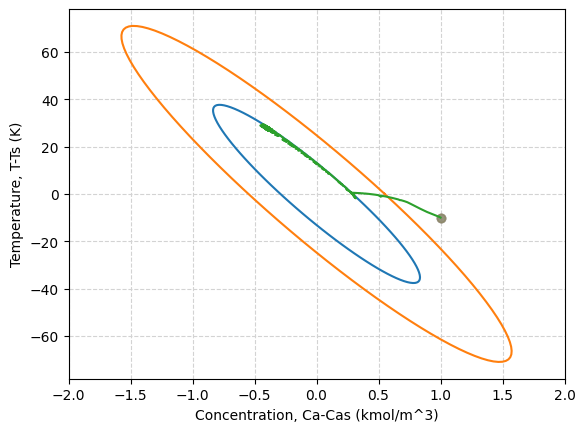

In [4]:
import numpy as np
import pickle, os
from matplotlib import pyplot as plt
from math import pi, cos, sin
#plt.rcParams['text.usetex'] = True

A, B, C, F = 1060, 44, 0.52, -90
A2, B2, C2, F2 = 1060, 44, 0.52, -320
angle = 0.5*np.arctan(B/(A-C)) # rotation angle
A_prime = A*(cos(angle))**2 + B*cos(angle)*sin(angle) + C*(sin(angle))**2
C_prime = A*(sin(angle))**2 - B*cos(angle)*sin(angle) + C*(cos(angle))**2
a = np.sqrt(-F/A_prime) # radius on the x-axis
b = np.sqrt(-F/C_prime) # radius on the y-axis
C_A_limit = np.sqrt(a**2*(cos(angle))**2+b**2*(sin(angle))**2)
T_limit = np.sqrt(a**2*(sin(angle))**2+b**2*(cos(angle))**2)

A_prime2 = A2*(cos(angle))**2 + B2*cos(angle)*sin(angle) + C2*(sin(angle))**2
C2_prime = A2*(sin(angle))**2 - B2*cos(angle)*sin(angle) + C2*(cos(angle))**2
a2 = np.sqrt(-F2/A_prime2) # radius on the x-axis
b2 = np.sqrt(-F2/C2_prime) # radius on the y-axis
C_A_limit = np.sqrt(a**2*(cos(angle))**2+b**2*(sin(angle))**2)
T_limit = np.sqrt(a**2*(sin(angle))**2+b**2*(cos(angle))**2)

u,v = 0, 0 # Unstable

t = np.linspace(0, 2*pi, 100)
Ell = np.array([a*np.cos(t) , b*np.sin(t)]) #u,v removed to keep the same center location
R_rot = np.array([[cos(angle) , -sin(angle)],[sin(angle) , cos(angle)]]) #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    
Ell2 = np.array([a2*np.cos(t) , b2*np.sin(t)]) #u,v removed to keep the same center location
R_rot2 = np.array([[cos(angle) , -sin(angle)],[sin(angle) , cos(angle)]]) #2-D rotation matrix

Ell_rot2 = np.zeros((2,Ell2.shape[1]))
for i in range(Ell2.shape[1]):
    Ell_rot2[:,i] = np.dot(R_rot2,Ell2[:,i])

plt.plot(u+Ell_rot[0,:], v+Ell_rot[1,:])
plt.plot(u+Ell_rot2[0,:], v+Ell_rot2[1,:])# Rotated ellipse
for i in range(10):
    plt.plot(x1_record[0], x2_record[0], 'o', alpha=0.2)
plt.plot(x1_record, x2_record)
plt.grid(color='lightgray',linestyle='--')
plt.xlim(-2,2)
plt.xlabel('Concentration, Ca-Cas (kmol/m^3)')
plt.ylabel('Temperature, T-Ts (K)')
plt.savefig('ellipse.pdf')

In [5]:
sum(-k0*numpy.exp(-E/(R*(numpy.array(x2_record)+T1_s)))*(numpy.array(x1_record)+CA_s)**2)*delta

-16.894975711112927

In [6]:
u1_record

[-0.34765625,
 -1.1015625,
 -0.921875,
 -1.44921875,
 -1.23828125,
 -0.9765625,
 -0.78515625,
 -0.6640625,
 -0.6015625,
 -0.5859375,
 -0.68359375,
 -0.4296875,
 -0.3984375,
 -0.4453125,
 -0.67578125,
 -0.53515625,
 -0.58203125,
 -0.625,
 -0.67578125,
 -0.27734375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.703125,
 -0.703125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5625,
 -0.5625,
 0.0,
 2.515625,
 -2.43359375,
 -0.08203125,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0390625,
 -0.0390625,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3828125,
 -0.3828125,
 0.0,
 0.29296875,
 -0.29296875,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.2109375,
 2.21875,
 2.2578125,
 3.44140625,
 3.5,
 -2.75,
 1.33203125,
 0.796875,
 0.5078125,
 0.67578125,
 -1.2734375,
 1.671875,
 -1.26953125,
 1.828125,
 0.41796875,
 -1.1484375,
 1.3125,
 0.640625,
 -1.3984375,
 1.5625,
 -1.421875,
 1.6796875,
 -1.546875,
 2.5625,
 0.26171875,
 0.2734375,
 0.2

In [44]:
import time
import numpy as np
import matplotlib.pyplot as plt
import cyipopt
from cyipopt import minimize_ipopt
from phe import paillier
from IPython.display import display, Math, Latex, Markdown

B=1.0e5   # in Gauss
fce = 1.80e6 * B 

display(Latex(r'Electron gyrofrequency $f_{ce}$= %0.5e ' % fce))
display(Latex(r'\begin{align} a &= \frac{1}{2} \\ b &= \frac{1}{3} \\ c &= \frac{1}{4} \end{align}'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Encryption

In [45]:
public_key, private_key = paillier.generate_paillier_keypair(n_length=128)
d1=8
l1=28
l2=36#l2>=l1+d1
Q_l = -2**(l1-d1-1);
Q_u = 2**(l1-d1-1) - 2**(-d1);
def quant1(val):
    return np.fmin(np.fmax(np.round(val/(2**(-d1)))*(2**(-d1)),Q_l),Q_u)
def quant2(val):
    return int((2**d1)*val%(2**l2))
def quant3(val):
    return np.where((val%(2**l2))>=(2**(l2-1)),(val%(2**l2)) - (2**l2),(val%(2**l2)))/(2**d1)

# Encryption

In [49]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.23.0
ipykernel        : 6.29.4
ipywidgets       : not installed
jupyter_client   : 8.6.1
jupyter_core     : 5.7.2
jupyter_server   : 2.13.0
jupyterlab       : 4.1.5
nbclient         : 0.10.0
nbconvert        : 7.16.3
nbformat         : 5.10.3
notebook         : 7.1.2
qtconsole        : not installed
traitlets        : 5.14.2


In [ ]:


start_time = time.time();


    
######### Simulation time #########################

delta               = 1e-2                               #hr Sampling Time
hc                  = 1e-4                               #hr Numerical Integration Step Size
tFinal              = 1                                  #hr Total Simulation Time(including multiple runs)

###################################### MPC simulation constants ##############################################

netTimeSteps         = int(tFinal / hc )                    # Number of calculated steps
integrationTimeSteps = int(delta  / hc )                    # Number of steps per horizon  
controlTimeSteps     = 5                                   # Number of times Sensor data is read
#NUM_MPC_ITERATION    = int(tFinal/(delta*controlTimeSteps)) # Number of times simulation is run
NUM_MPC_ITERATION    = int(tFinal / delta ) # Number of times simulation is run

NUM_OUTPUTS          = 2                                    # Model Outputs: x1 x2 
NUM_INPUTS           = 4                                    # Model  Inputs: u1 u2 x1 x2
NUM_U                = int(NUM_INPUTS-NUM_OUTPUTS)          # Number of control inputs



NUM_MPC_INPUTS      = int(NUM_U*controlTimeSteps)            # 1 set of control inputs per Horizon 
NUM_MPC_CONSTRAINTS = controlTimeSteps                       # Constraints must be satisfied at all points

################### P matrix #############################
#V= xTP(x) "Energy of Sys"

a = 1060 
b = 22
d = 0.52

###########Q Matrices for Cost Function##############
#Qx=np.diag(np.tile([2e3, 1], int(NUM_OUTPUTS/2)))
#Qu=np.diag(np.tile([8e-13, 0.001], int(NUM_OUTPUTS/2)))
A1 = np.array([1, 0.99, 1.01, 0.98, 1.02])
A2 = np.array([17, 14, 5, 7, 9])
A3 = np.array([1e-8, 0.8*1e-8, 0.84*1e-8, 0.9*1e-8, 0.92e-8])

#################### PI Controler Weights ###########
proportionalGainConcentration = 10
proportionalGainHeat          = 10000
integralGain                  = 0.01

##################### initial values and initializations ######################

#Initial Values in Deviation Variable Form
CA_real         = 1.75 #kmol/m3
T_real          = -40 #K

x_record        = np.zeros((NUM_OUTPUTS,NUM_MPC_ITERATION+1))
x_real   = np.array([[CA_real],[T_real]])
x_record[:,[0]] = x_real



u_record        =np.zeros((NUM_U,NUM_MPC_ITERATION))
offset_record   = []
grad_f_record   = []
cost_record     = []

V_record        = []
CostFun         = []
status_record   = []

realtime_data   = None
cost            = 0.0

################################ Parameters ######################

#Flowrate Terms
F      = 5       #m^3/hr
V      = 1       #m^3

#Thermochemical Properties
rhoe_L = 1e3     #kg/m3
Cp     = 0.231   #kJ/kg-K
deltaH = -1.15e4 #kJ/kmol
E      = 5e4     #kJ/kmol
R      = 8.314   #kJ/kmolK 
k0     = 8.46e6  #m3/kmol-h

#Thermal Properties
T0     = 300     #K

###################Simplifications################################
E_over_R = -E/R                       #K
Coeff1   = (F/V)
Coeff2   = ((deltaH*k0)/(rhoe_L*Cp))
Coeff3   = (V*rhoe_L*Cp)
######################## steady state values ########################
#Invariant Parameters
T0s  = 300          #K

#State Variables
CAs  = 1.954        #kmol/m3
Ts   = 401.9        #K

#Control Variables
Qs   = 0.0          #kJ/hr
CA0s = 4            #kmol/m3

#################################################
################## MPC PROGRAM ##################
#################################################
#def equalityConstraints(x):#f(x) + C= 0
#    return np.sum(x**2) - 40 
#def inequalityConstrains(x):#f(x) + C >= 0
#    return np.prod(x) - 25  
#cons = [
#    {'type': 'eq', 'fun': equalityConstraints, 'jac': equalityConstraints_Jacobian, 'hess': equalityConstraints_Hessian},
#    {'type': 'ineq', 'fun': inequalityConstrains, 'jac': inequalityConstrains_Jacobian, 'hess': inequalityConstrains_Hessian}
# ] 
############################################################################################################
##################################### Cost Function#########################################################
############################################################################################################
def eval_f(u):#L=xQx+uRu
    #print("eval_f:",u)
    assert len(u) == int(NUM_MPC_INPUTS)
    #Define initial Guesses
    offset = 0
    x      = x_real
    
    #Define the initial values of the State Variables
    CA  = x.item(0)
    T   = x.item(1)
    #print('X is ',x)
    #print('U is ',u)
    ##Numerical Integration
    ### check how to write the inputs
    for jj in range(controlTimeSteps):
        #Define the initial values of the Control Variables
        CA0 = u.item(NUM_U*jj+0)
        Q   = u.item(NUM_U*jj+1)
        for jjj in range(integrationTimeSteps):#Newtons Method x=u, x1&x2 = x
            
            #Define the final values of the State Variables
            CA  = x.item(0)
            T   = x.item(1)
            

            #Functions shown before converting to Deviation Variable Form
            #fun_1= (F/V)*(CA0)-(F/V)*(CA1)-k0*np.exp(E_over_R/(T))*(CA1)**2
            #fun_2= (F/V)*(T0)-(F/V)*(T)-((deltaH*k0)/(rhoe_L*Cp))*np.exp(E_over_R/(T))*(CA1)**2+(Q)/(rhoe_L*Cp*V)
            #Coeff1=(F/V)
            #Coeff2=((deltaH*k0)/(rhoe_L*Cp))
            #Coeff3=(V*rhoe_L*Cp)
            #CA,T,CA0, and Q are in deviation variable form
            #T0 is not in deviation variable form      
    
            fun_1 = Coeff1*(CA0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2
            fun_2 = Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(Q)/Coeff3
            
            #Use Newtons Method to iterate
            #x1Dot = fun_1 and so on
            x     = x + hc*np.array([[fun_1],[fun_2]])  
        #Define the final values of the State Variables
        CA  = x.item(0)
        T   = x.item(1)    
        ##Sum the Cost Function over every HORIZON
        offset = offset -k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2
    #print('f=',offset*delta)
    return offset*delta

##################################### Cost Function Derivative ###############################################

def eval_grad_f(u):#Finite difference approximation of df/du
    #print("eval_grad_f:",u)
    assert len(u) == int(NUM_MPC_INPUTS)
    step = 1.e-3 # we just have a small step
    objp=objm=0
    grad_f = [0]*NUM_MPC_INPUTS
    upstep = [0]*NUM_MPC_INPUTS
    umstep = [0]*NUM_MPC_INPUTS
    for i_mpc_input in range(NUM_MPC_INPUTS):
        upstep=u.copy()
        umstep=u.copy()
        # for each variables, we need to evaluate the derivative of the function with respect to that variable, This is why we have the for loop
        upstep[i_mpc_input]  = upstep[i_mpc_input]+step 
        umstep[i_mpc_input] = umstep[i_mpc_input]-step
        #print ("step: ", step)
        #print ("up:  ",upstep)
        #print ("um:  ",umstep)
        #print ("i_mpc_input:  ",i_mpc_input)
        # Evaluate the objective function at upstep and umstep
        objp=eval_f(upstep) # This function returns the value of the objective function evaluated with the variable u[i] is perturebed +step
        objm=eval_f(umstep) # This function returns the value of the objective function evaluated with the variable u[i] is perturebed -step
        #print ("obj ", objp, "   objm   ", objm)
        grad_f[i_mpc_input] = (objp - objm) / (2 * step) # This evaluates the gradient of the objetive function with repect to the optimization variable x[i]
    #print("Gradient: ", grad_f)
    
    grad_f_record.append(grad_f)
    return np.array(grad_f)

############################################################################################################
##################################### Constraints ##########################################################
############################################################################################################
def eval_g(u):#V condition, Vdot condition, the Energy constraint
    #print("eval_g:",u)
    assert len(u) == int(NUM_MPC_INPUTS)
    g = np.array([-1.0]*(controlTimeSteps))  #Default to <0 i.e valid
    
    #LMPC Controller Version 
    #Define the initial values of the State Variables
    x=x_real
    CA=x.item(0)
    T=x.item(1)
    #If V=x*P*x, then Vdot=2x*P*f + 2x*P*g*u         
    #Recall that xDot=f+g*u
    #Recall further that P is of the form= [a,b;b,d]
    #Explicitly, this gives: (make sure all instances of u are replaced with 0)
    #In this system, u=CA0 and Q
    #LfV = (2 * a * CA1 + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
    #      (2 * d * T + 2 * b * CA1) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 ) + \
    #All the Q terms are instead moved here
    #Lg1V= (2 * a * CA1 + 2 * b * T)*Coeff1
    #Lg2V = (2 * d * T + 2 * b * CA1) / Coeff3
    #Coeff1=(F/V)
    #Coeff2=((deltaH*k0)/(rhoe_L*Cp))
    #Coeff3=(V*rhoe_L*Cp)
    #Note that if its known that LfV cancels you can just set it equal to 0   
    
    #LfV  = (2 * a * CA + 2 * b * T) * ( Coeff1*(0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2 ) + \
    #       (2 * d * T + 2 * b * CA) * ( Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(0)/Coeff3 )
    LfV = 0
    Lg1V = (2 * a * CA + 2 * b * T) * Coeff1
    Lg2V = (2 * d * T + 2 * b * CA) / Coeff3
    
    #xdot = F = f(x) + g(x)u
    #Vdot = LfV(x)+LgV(x)*u      
    dV_op2=LfV+Lg1V*u.item(0)+Lg2V*u.item(1) #Using EMPC
    
    #using P controller [Backup controller{We want LEMPC to be better than this}]
    ###########Not Defined for system yet
    kc1 = 2
    kc2 = 12000
    u11= kc1*(0-CA)
    u22= kc2*(0-T)
    dV_Pu2=LfV+Lg1V*u11+Lg2V*u22 #Using Backup Controller
    
    #If g is negative, EMPC is smaller than the Backup Controler{Better}
    #We use g as an array in case there are multiple controllers used as constraints
    V_secure=90
    V_predicted=(a*CA**2) + 2*(b*CA*T) + (d*T**2)

    #print('Xg is ',x)
    #print('Ug is ',u)       
    if V_predicted<=V_secure:
        for controlIteration in range(controlTimeSteps):
            #Define the initial values of the Control Variables
            CA0 = u.item(NUM_U*controlIteration+0)
            Q   = u.item(NUM_U*controlIteration+1)
            for _ in range(integrationTimeSteps):#Newtons Method x=u, x1&x2 = x
                #Define the initial values of the State Variables
                CA  = x.item(0)
                T   = x.item(1)             
                
                #Functions shown before converting to Deviation Variable Form
                #fun_1= (F/V)*(CA0)-(F/V)*(CA1)-k0*np.exp(E_over_R/(T))*(CA1)**2
                #fun_2= (F/V)*(T0)-(F/V)*(T)-((deltaH*k0)/(rhoe_L*Cp))*np.exp(E_over_R/(T))*(CA1)**2+(Q)/(rhoe_L*Cp*V)
                #Coeff1=(F/V)
                #Coeff2=((deltaH*k0)/(rhoe_L*Cp))
                #Coeff3=(V*rhoe_L*Cp)
                #CA,T,CA0, and Q are in deviation variable form
                #T0 is not in deviation variable form      
        
                fun_1 = Coeff1*(CA0-CA)-k0*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+k0*np.exp(E_over_R/(Ts))*(CAs)**2
                fun_2 = Coeff1*(T0-T0s-T)-Coeff2*np.exp(E_over_R/(T+Ts))*(CA+CAs)**2+Coeff2*np.exp(E_over_R/(Ts))*(CAs)**2+(Q)/Coeff3
                
                #Use Newtons Method to iterate
                #x1Dot = fun_1 and so on
                x     = x + hc*np.array([[fun_1],[fun_2]])  
            #Define the initial values of the State Variables
            CA  = x.item(0)
            T   = x.item(1) 
            #print('CA is ',CA)
            #print('T is ',T)
            g[controlIteration]=((a*CA**2) + 2*(b*CA*T) + (d*T**2)) - V_secure
    else:
        g[0]=dV_op2-min(0,dV_Pu2-0.000065) #Difference of MPC and P, Vdot
    
    # # Material constraint
    # material_used = np.sum(u_record[[0],:])
    # if main_iteration <= NUM_MPC_ITERATION - controlTimeSteps - 1:
    #     for controlIteration in range(controlTimeSteps):
    #         material_used = material_used + u.item(NUM_U*controlIteration+0)
    # else:
    #     for controlIteration in range(NUM_MPC_ITERATION - main_iteration):
    #         material_used = material_used + u.item(NUM_U*controlIteration+0)
    # g[-1] = 0 - material_used
    #print("-g is ", -g)
    return -g


##################################### Constraints Derivative ##########################################################
def equalityConstraints(u):#f(x) + C= 0
    #print("equalityConstraints:",u)
    # Material constraint
    material_used = np.sum(u_record[0])
    if main_iteration <= NUM_MPC_ITERATION - controlTimeSteps - 1:
        for controlIteration in range(controlTimeSteps):
            material_used = material_used + u.item(NUM_U*controlIteration+0)
    else:
        for controlIteration in range(NUM_MPC_ITERATION - main_iteration):
            material_used = material_used + u.item(NUM_U*controlIteration+0)
    #print("past u is ",np.sum(u_record[0]))
    #print("u is ",u)
    #print("material_used is ", material_used)
    return material_used - 1
def eval_jac_g(x):
    #print("eval_jac_g:",x)
    assert len(x) == int(NUM_MPC_INPUTS)
    step = 1e-1 # we just have a small step
    gp=gm=np.zeros(NUM_MPC_CONSTRAINTS)
    xpstep=xmstep=np.zeros(NUM_MPC_INPUTS)
    jac_g = [[0]*int(NUM_MPC_INPUTS) for _ in range(NUM_MPC_CONSTRAINTS)]
    #print ("shape:", jac_g)
    for i_mpc_input in range(NUM_MPC_INPUTS):
        xpstep=x.copy()
        xmstep=x.copy()
        xpstep[i_mpc_input] += step
        xmstep[i_mpc_input] -= step
        gp=eval_g(xpstep)
        gm=eval_g(xmstep)
        for num_constraint in range(NUM_MPC_CONSTRAINTS):
            jac_g[num_constraint][i_mpc_input] = (gp[num_constraint] - gm[num_constraint]) / (2 * step)
    return np.array(jac_g)
############################################################################################################
############################################################################################################
############################################################################################################
cons = [
   {'type': 'eq', 'fun': equalityConstraints},
   {'type': 'ineq', 'fun': eval_g, 'jac': eval_jac_g}
]
u_L=[]
u_U=[]
lowerBounds=[-3.5,-5e5]
upperBounds=[3.5 ,5e5]
for _ in range(controlTimeSteps):
    u_L=u_L+lowerBounds
    u_U=u_U+upperBounds                                       
bnds = [(u_L[_], u_U[_]) for _ in range(NUM_MPC_INPUTS)]